In this notebook we will bulild four different portfolios, based on stocks Alpha, Beta, Volatility and Equiweight.
Rebalance individual stock weights after a period of 60 trading days and then evaluate Associated Risk and Return of each portfolio for each period and cumulative Result of each portfolio strategy. 

In [1]:
import datetime
import pandas as pd
import time
from scipy.stats import linregress
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

In [2]:
stocks= pd.read_csv('names.csv')
names=[name+'.NS' for name in stocks.Symbol]
names.insert(0,'%5ENSEI')
days=3000
period=60
n_stocks=30

# Data Minning From Yahoo Finance

In [3]:
def get_data(names, days):
    t2=int(time.mktime((datetime.date.today() - datetime.timedelta(1)).timetuple())+19800)
    t1=int(time.mktime((datetime.date.today() - datetime.timedelta(days)).timetuple())+19800)
    df= pd.DataFrame()
    for name in names:
        try:
            url='https://query1.finance.yahoo.com/v7/finance/download/' \
                +name+'?period1='+str(t1)+'&period2='+str(t2)+'&interval=1d&events=history&includeAdjustedClose=true'

            if name!= '%5ENSEI':
                a= pd.read_csv(url)
                a=a.loc[:][['Date','Adj Close']].rename(columns={'Adj Close':name[:-3]})
                if len(a)> 0.6*days:
                    df=df.merge(a, on='Date')
                    #print(name[:-3]+' success')
                else:
                    #pass
                    print(name[:-3]+' small size')
            else:
                a= pd.read_csv(url)
                df=a.loc[:][['Date','Adj Close']].rename(columns={'Adj Close':'NIFTY'})
                #print('NIFTY success')
        
        except Exception as e:
            print(name, e)
    df.Date=pd.to_datetime(df.Date)    
    return df

In [4]:
df=get_data(names,days).dropna(axis=0)

HDFCLIFE small size
SBILIFE small size


In [5]:
df.reset_index(inplace= True, drop = True)
dates=df.pop('Date')

# Relation between individual daily return of a stock and NIFTY

<AxesSubplot:xlabel='NIFTY', ylabel='HINDUNILVR'>

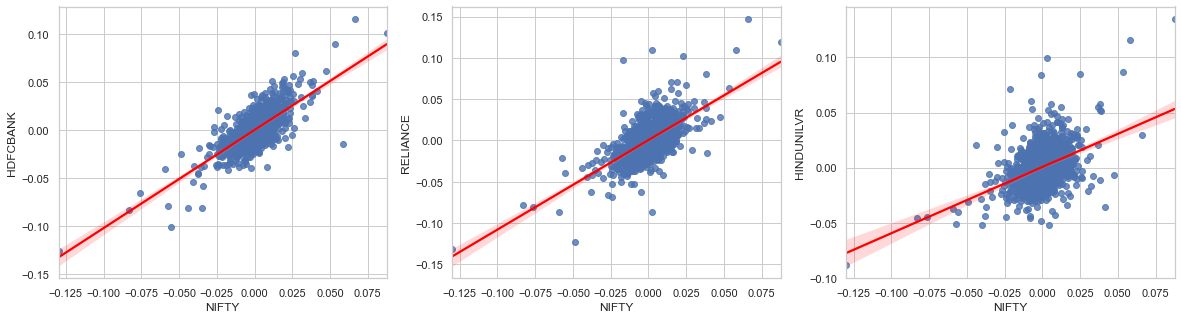

In [6]:
dfr= df.div(df.shift())-1
dfr.dropna(axis=0,inplace=True)

fig,axes= plt.subplots(1, 3, figsize=(20, 5), sharey=False)
sns.regplot(ax=axes[0], data=dfr, x= 'NIFTY', y= 'HDFCBANK',  line_kws={"color": "red"})
sns.regplot(ax=axes[1], data=dfr, x= 'NIFTY', y= 'RELIANCE',  line_kws={"color": "red"})
sns.regplot(ax=axes[2], data=dfr, x= 'NIFTY', y= 'HINDUNILVR',  line_kws={"color": "red"})


# Finding values of Alpha, Beta and Voatility for each stock.

In [7]:
def get_data(df_return,d1,d2, num_stocks=n_stocks):
    nifty_return=df_return.pop('NIFTY')
    data=pd.DataFrame()
    
    for column in df_return.columns:
        try:
            slope, intercept,_1,_2,_3=linregress(nifty_return[d1:d2],df_return[column][d1:d2])
            vol=(1/(np.std(df_return[column][d1:d2])*pow(len(df_return[column][d1:d2]), 0.5)+0.0000001))
            data[column]= [slope, intercept,vol]
        except Exception as e:
            print('help', e)
            pass
    data=data.T.rename(columns={0:'Beta',1:'Alpha',2:'Volatility'})

    return data

# Assiging weights(percentage of capital to invest) for each stock

In [8]:
def assign_weights(df_return,d1,d2, num_stocks=n_stocks):
    data=get_data(df_return,d1,d2)
    for column in data.columns:
        a= data.loc[data.sort_values(by= column, ascending = False)[:num_stocks].index][column]
        data[column+'_weighted']= a.div(sum(a))
        data[column+'_eq_weighted']=pd.Series([1/len(a)]*len(a), index= a.index)
        del data[column]
    weights=data.fillna(0).copy()
    return weights

# Evaluation of generated porfolios

Calculating Associated Risk(STDEV), Return over a certain period 

In [9]:
def evaluate(df,d1, d2, d3, num_stocks=n_stocks):
    df_return= df.div(df.shift())-1
    df_return.dropna(axis=0,inplace=True)
    nifty_return=df_return['NIFTY']
    weights=assign_weights(df_return,d1,d2)
    
    
    df_n= df[d2:d3].div(df.iloc[d2,:]).iloc[-1,:]
    
    ret=df_return.T
    

    d={}
    for column in weights.columns:
        returns= ret.iloc[:,d2:d3].apply(lambda x: sum(x*weights[column]))
        ax=np.std(returns)*pow(len(returns),0.5)*100
        d[column]=[(sum((df_n*weights[column]).dropna())- 1)*100, ax]
    nifty= df.NIFTY[d2:d3]
    d['Nifty']=[(nifty.div(nifty[d2]).to_list()[-1]-1)*100, np.std(nifty_return[d2:d3])*pow(len(nifty_return[d2:d3]),0.5)*100]
    final=pd.DataFrame(d, index=['Return','Risk']).T
     
    return final

In [10]:
def f_plot(a):
    plt.figure()
    for index in a.index:
        plt.scatter(a.loc[index]['Risk'],a.loc[index]['Return'] ,s=50)
    plt.grid(True)
    plt.legend(a.index)
    plt.xlabel('Associated Risk(STDEV)')
    plt.ylabel('Percentage Return')
    plt.show()

In [11]:
def final(df,period, num_stocks=n_stocks):
    periods=[x*period for x in range(0,int(len(df)/period)+1)]
    periods= [ periods[i:i+3] for i,x in enumerate(periods) if len(periods[i:i+3])==3]
    ret=[]
    risk=[]
    print(len(periods))
    for p in periods:
        a=evaluate(df, p[0],p[1],p[2], num_stocks)
        ret.append(a['Return'].values)
        risk.append(a['Risk'].values)
        f_plot(a)
    return a.index, [ret,risk]

# Result for individual periods

Weights of stocks in each portfolio is rebalanced after 30 days, based on market behaviour for previous 60 days

32


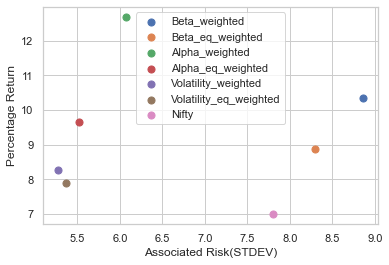

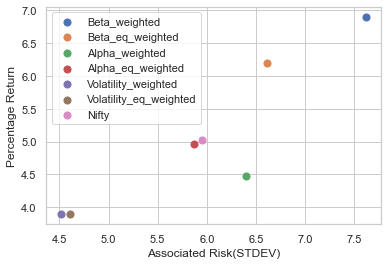

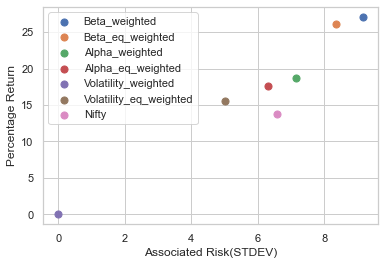

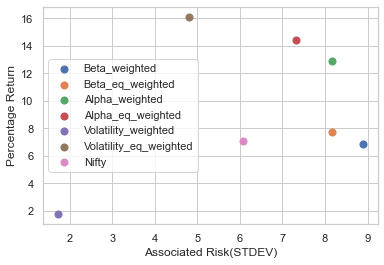

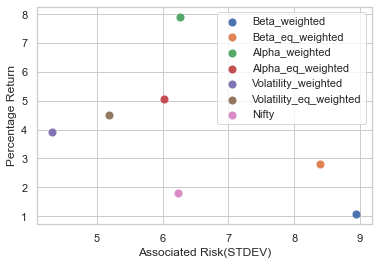

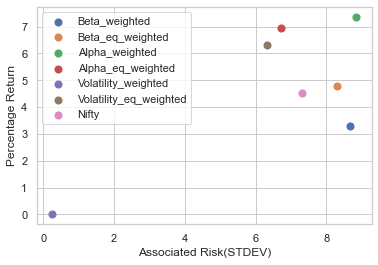

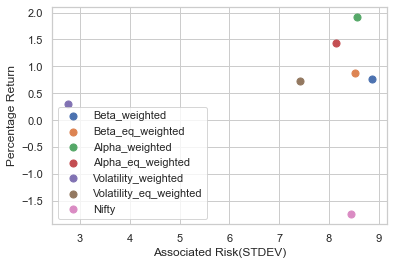

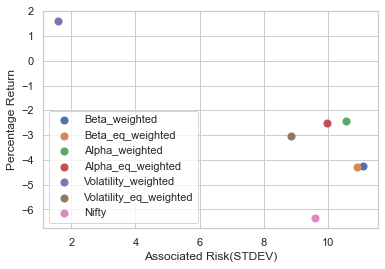

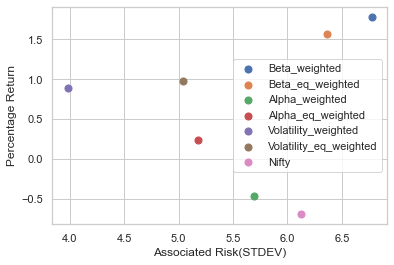

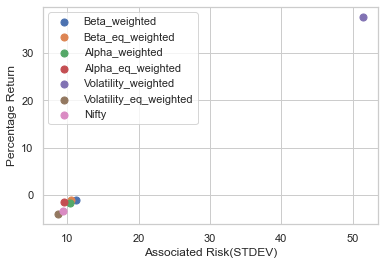

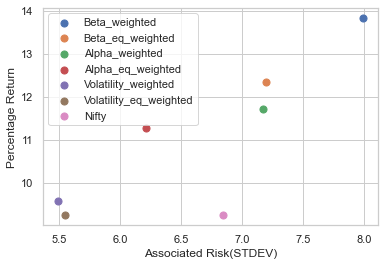

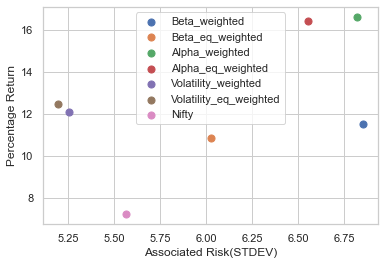

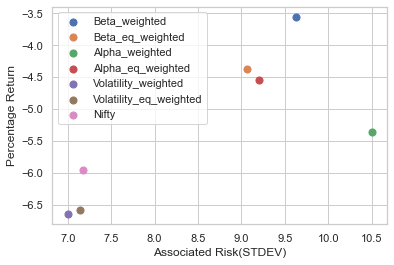

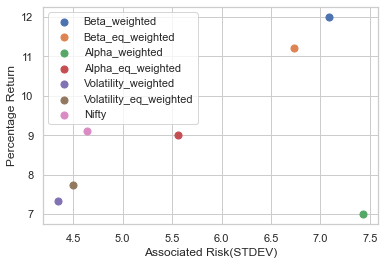

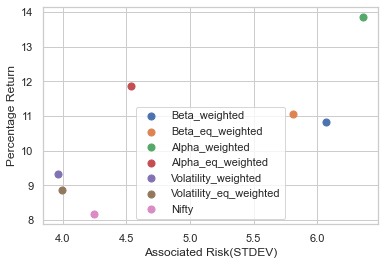

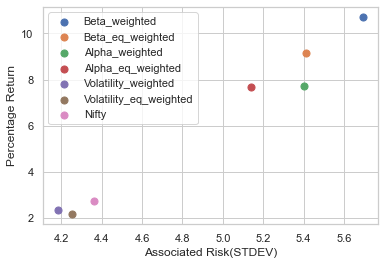

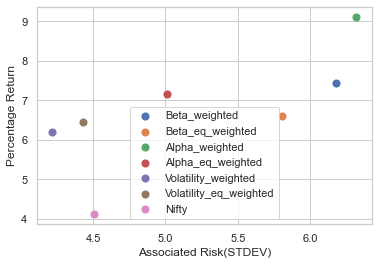

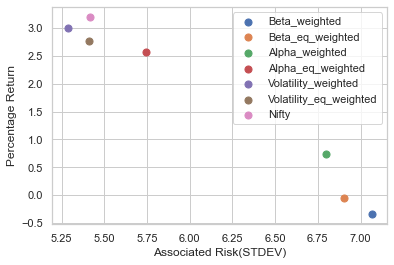

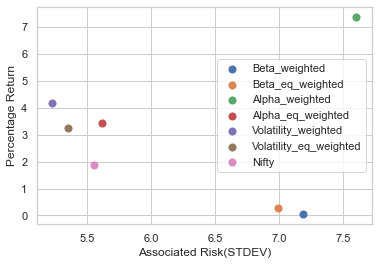

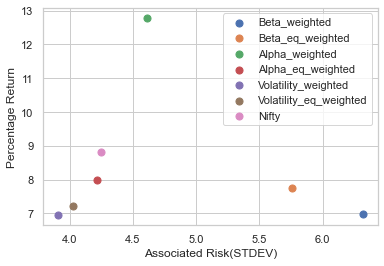

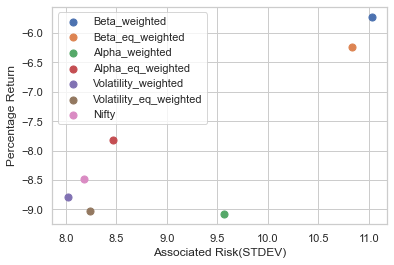

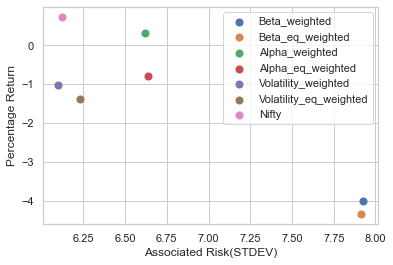

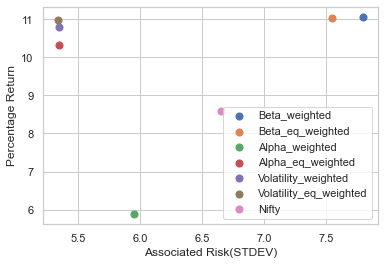

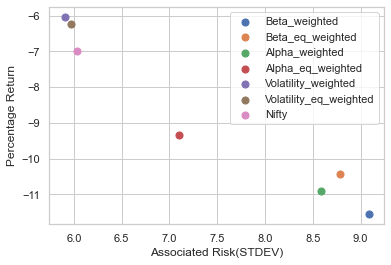

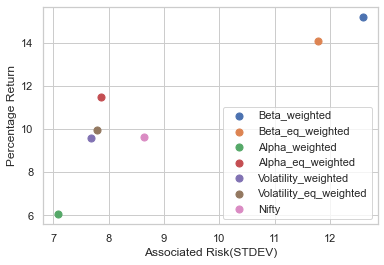

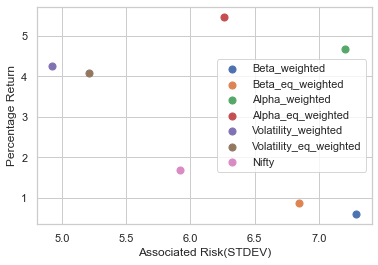

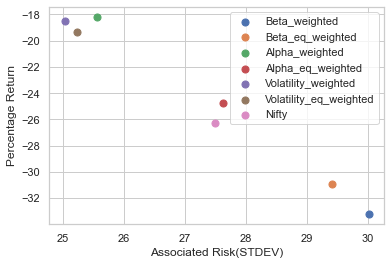

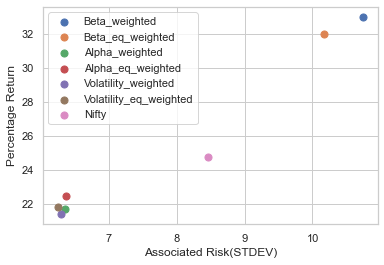

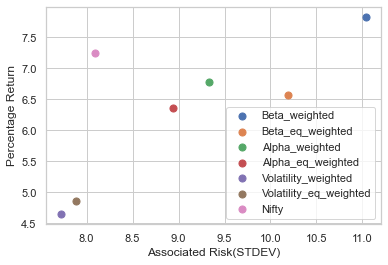

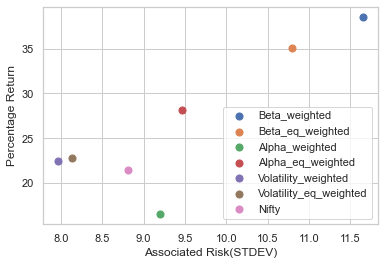

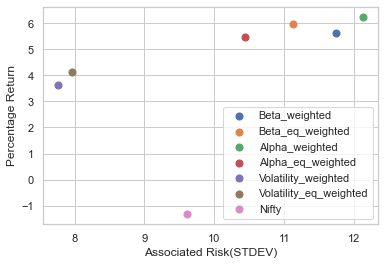

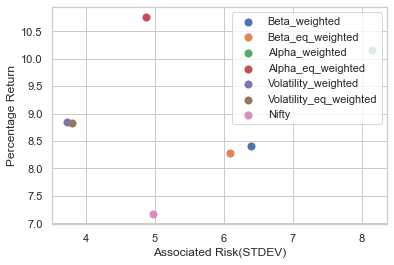

In [12]:
p, f=final(df,60,n_stocks)

# Cumulative Risk and Return of each Portfolio

In [13]:
def cum_ret(x):
    y=100
    for i in x:
        y=y*(1+(i/100))
    return round(y,2)
a=pd.DataFrame(f[0], columns=p)
p=a.columns
a=a.apply(lambda x: cum_ret(x))

In [14]:
a # Cumulative Return of each portfolio

Beta_weighted             490.36
Beta_eq_weighted          468.86
Alpha_weighted            530.38
Alpha_eq_weighted         535.51
Volatility_weighted       433.55
Volatility_eq_weighted    403.32
Nifty                     268.45
dtype: float64

In [15]:
b=np.sqrt(pd.DataFrame(f[1]).pow(2).sum()) # Cumulative Risk for each portfolio

Text(0, 0.5, 'Percentage Return')

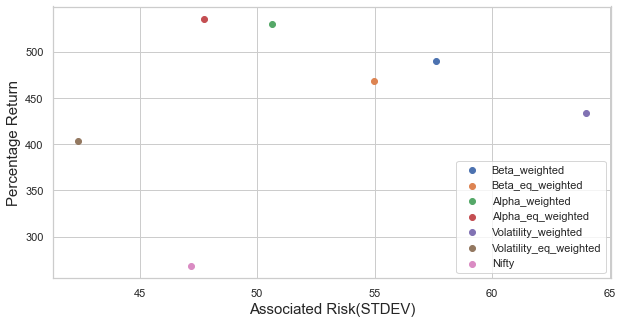

In [16]:
plt.figure(figsize=(10,5))
for i in range(len(p)):
    plt.scatter(b[i],a[i])
plt.grid(True)
plt.legend(p)
plt.xlabel('Associated Risk(STDEV)', fontsize=15)
plt.ylabel('Percentage Return', fontsize=15)